In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import scipy.sparse.linalg
import torch
import re
from torch.nn.functional import conv2d
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from crf.utils import read_image, read_pfm, read_pgm
from crf.features import Vgg16features
from crf.crf import *
from crf.depth import *

In [52]:
img1 = read_image('imL.png')#[::2,::2]
img2 = read_image('imR.png')#[::2,::2]
gt_depth = read_pgm('truedisp.row3.col3.pgm')
#img1 = read_image('im0.png')[::3,::3]
#img2 = read_image('im1.png')[::3,::3]
#gt_depth = read_pfm('disp0.pfm')[::3,::3]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [227]:
## Hyper parameters
ws = 9      # Disparity aggregation window size
gamma = 3    # Charbonneir turning point
sigma_c = .1 # Filter stdev for color channels
sigma_p = .1 # Filter stdev for position channels
sigma_f = 10 # Filter stdev for feature channels
n_iters = 30 # Number of mean field message passing iterations

In [228]:
# Get the unary potentials from window sweep
disp_energy = disparity_badness(img1,img2,ws)
disps = np.argmin(disp_energy,axis=-1)
L = disp_energy.shape[-1] # Number of possible disparities
downsampled_out = disp_energy[::4,::4]
h,w,_ = downsampled_out.shape
n = h*w

E_0 = torch.from_numpy(downsampled_out.reshape(-1,L)).float().to(device)

In [229]:
# Setup the compatibility matrix
labels = torch.arange(L).float()
charb = lambda a,b: charbonneir(a,b,gamma)
Mu = compatibility_matrix(charb,labels).to(device)

In [230]:
# Get random projection of VGG16 features
VGG = Vgg16features()
VGG.to(device)
q = 2
features = VGG.get_random_features(img1,i=q)
feats = (features - features.mean((0,1)))/features.std((0,1))

In [231]:
# Calculate W matrix with brute force
position = np.mgrid[:h,:w].transpose((1,2,0))/np.sqrt(h**2+w**2)
ref = np.zeros((h,w,5))
ref[...,:3] = img1[::4,::4]/sigma_c
ref[...,3:5] = position/sigma_p
#ref[...,5:] = feats[::2**(2-q),::2**(2-q)]/sigma_f
flat_ref = torch.from_numpy(ref.reshape(n,-1).astype(np.float32))
W = gaussian_weights(flat_ref.to(device))
img_W = W.reshape((h,w,h,w))

In [232]:
mf = mean_field_infer(E_0,W,Mu,n_iters)
expected_depths = mf@labels.to(device)
crf_depth = expected_depths.reshape(h,w).cpu().numpy()

Text(0.5, 1.0, 'Ground Truth')

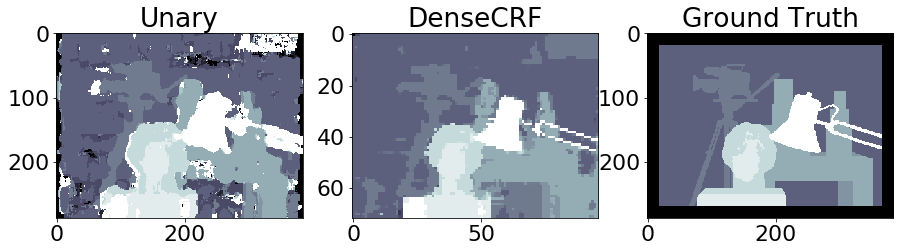

In [233]:
plt.rcParams.update({'font.size': 22})
f, axarr = plt.subplots(1,3,figsize=(15,10))
a0 = axarr[0].imshow(4*disps,cmap='bone',vmin=0,vmax=L//2)
a1 = axarr[1].imshow(4*crf_depth,cmap='bone',vmin=0,vmax=L//2)
a2 = axarr[2].imshow(gt_depth,cmap='bone',vmin=0,vmax=4*L//2)
axarr[0].set_title("Unary")
axarr[1].set_title("DenseCRF")
axarr[2].set_title("Ground Truth")

(array([84868., 23399.,   438.,   440.,   337.,   249.,   176.,   386.,
          181.,   118.]),
 array([ 0. ,  9.5, 19. , 28.5, 38. , 47.5, 57. , 66.5, 76. , 85.5, 95. ]),
 <a list of 10 Patch objects>)

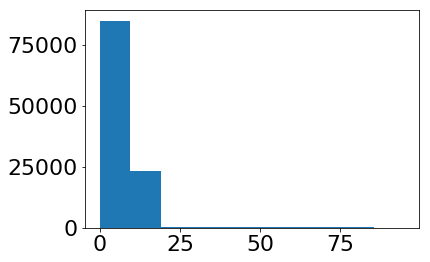

In [31]:
plt.hist(disps.reshape(-1))

(array([4.000e+00, 4.000e+00, 8.000e+00, 4.621e+03, 2.240e+02, 9.590e+02,
        3.120e+02, 4.720e+02, 1.800e+01, 2.900e+02]),
 array([2.2000386e-43, 1.5002233e+00, 3.0004466e+00, 4.5006700e+00,
        6.0008931e+00, 7.5011163e+00, 9.0013399e+00, 1.0501563e+01,
        1.2001786e+01, 1.3502009e+01, 1.5002233e+01], dtype=float32),
 <a list of 10 Patch objects>)

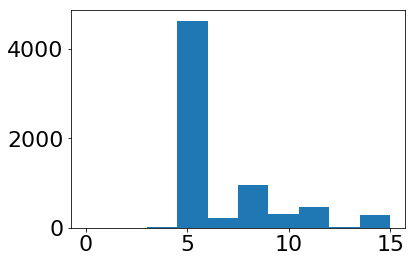

In [30]:
plt.hist(crf_depth.reshape(-1))

(array([22896.,     0.,     0., 50668.,  6595., 14324.,     0., 10385.,
            0.,  5724.]),
 array([  0. ,  22.4,  44.8,  67.2,  89.6, 112. , 134.4, 156.8, 179.2,
        201.6, 224. ]),
 <a list of 10 Patch objects>)

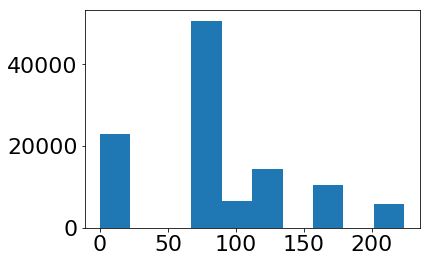

In [29]:
plt.hist(gt_depth.reshape(-1))

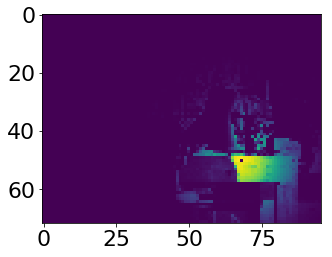

In [100]:
#plt.imshow(img_W[40,35])
plt.imshow(img_W[50,68])

In [ ]:
plt.hist(expected_depths.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


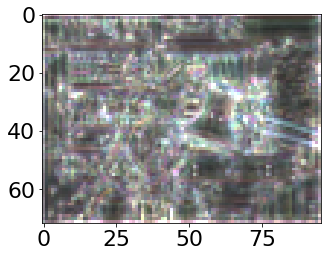

In [76]:
plt.imshow((feats[...,3:6]+3)/6)

In [68]:
feats[...,:3]

1.000000000000001